In [ ]:
import cv2
import numpy as np
import pandas as pd
import pylab as plt
import os 
import glob
from tqdm import tqdm
from numpy import pi

import skimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.feature import canny
from skimage import morphology
from skimage.morphology import convex_hull_image
from scipy import ndimage as ndi

plt.style.use ('seaborn')

In [ ]:
data_path= 'Adipo/data/**.tif'

L1= glob.glob(data_path)    # List names of raw data
print(len(L1))

938


In [ ]:
L2= [L1[i] for i in range (len(L1)) if L1[i].split ('/')[1] != '0' ]
len (L2)

938

# Functions

In [ ]:
# Function to apply thresholding

def img_loader (image):
    imgrgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)         #Modify color format
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)     #Reduce number of channels from 3 to 1
    #  Roberts operator
    kernelx = np.array([[-1, 0], [0, 1]], dtype=int)
    kernely = np.array([[0, -1], [1, 0]], dtype=int)
    x = cv2.filter2D(grayImage, cv2.CV_16S, kernelx)
    y = cv2.filter2D(grayImage, cv2.CV_16S, kernely)
    #  Convert to uint8
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)
    Roberts = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
    ret, thresh1 = cv2.threshold(Roberts, 120, 255, cv2.THRESH_BINARY + 
                                                            cv2.THRESH_OTSU)     
    sample= thresh1/255
    return sample, imgrgb

In [ ]:
# Function to amplify the thresholded images by scaning through it.
# This function checks if an small area by radius "r" is dense enough, 
# then will amplifies its density by filling the whole small area. 
# The threshold, r and other parameters are set by try & error procedures.


def modify_msk (modif, r=12):
    out= modif.copy()
    fill= np.ones ([r,r])
    sig= 6
    c= int(r/2)
    for i in range (r):
        for j in range (r):
            if np.sqrt(i**2+j**2) <r/3:
                fill[c-i:c+i,c-j:c+j]= 0
    fill= fill.astype(bool)
    for i in range (0, len (out)-r, int(r/2)):
        for j in range (0, len (out[0])-r, int(r/2)):
            if np.sum(out[i:i+r, j:j+r])<r**2/2:
                out[i:i+r, j:j+r] = out[i:i+r, j:j+r] & fill
    out= morphology.remove_small_objects(out, 5000)
    return out

In [ ]:
# Function to binerize and modify edges of masked areaa. 
# The outputs of thresholding process needs some modifications 
# in order to separate or merge disconnected area. 
# Parameters are set by try & error procedures.

def mask (image): 
    edges = canny(image, sigma= 8)
    edges = ndi.binary_dilation (edges, iterations= 15)
    canny_fill = ndi.binary_fill_holes(edges)
    erosioned = ndi.binary_erosion (canny_fill, iterations= 15)
    msk= modify_msk(erosioned).astype(int)
    # mask= modify_msk(canny_fill).astype(int)
    # return msk, canny_fill
    return msk, edges

In [ ]:
# Function for calculation of Convex Perimeter feature

def convex_perimeter (label):
    out1= convex_hull_image(label).astype (int)
    out= regionprops(out1)[0].perimeter
    return out

## Test

In [ ]:
# To visualise the outcome of every coded modification, This function will call the 
# relevant method and gives the outcome for n sample raw inputs:

def mask_process (n):
    Canny_f= []
    Masks= []
    Samples= []
    Raws= []
    Features= []
    Regions= []
    for _ in range (n):
        img= L2[np.random.randint(len(L2))]
        image1= cv2.imread (img)
        smpl, raw= img_loader(image1)
        msk, canny_f= mask(smpl)
        Canny_f.append(canny_f)
        Samples.append(smpl)
        Raws.append(raw)

        label_img = label(msk)
        regions= regionprops(label_img)
        benchmark= [regions[i].eccentricity <.91 for i in range (len (regions))]    # This is the benchmark for removing too long objects (non-spheroids)
        # regions1= list(compress(regions, benchmark))
        for j, ben in enumerate(benchmark):
            if not ben:
                label_img[label_img == j+1] = 0
        msk= label_img.astype (bool)
        Masks.append(msk)

        label_img = label(msk)

        props = regionprops_table(label_img, extra_properties=(convex_perimeter,), properties=('centroid', 'orientation', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'solidity', 
                                                  'perimeter', 'perimeter_crofton', 'area', 'convex_area',))
        df= pd.DataFrame(props)
        Features.append(df)

        regions = regionprops(label_img, )
        Regions.append(regions)
        
    return Masks, Canny_f, Samples, Raws, Features, Regions

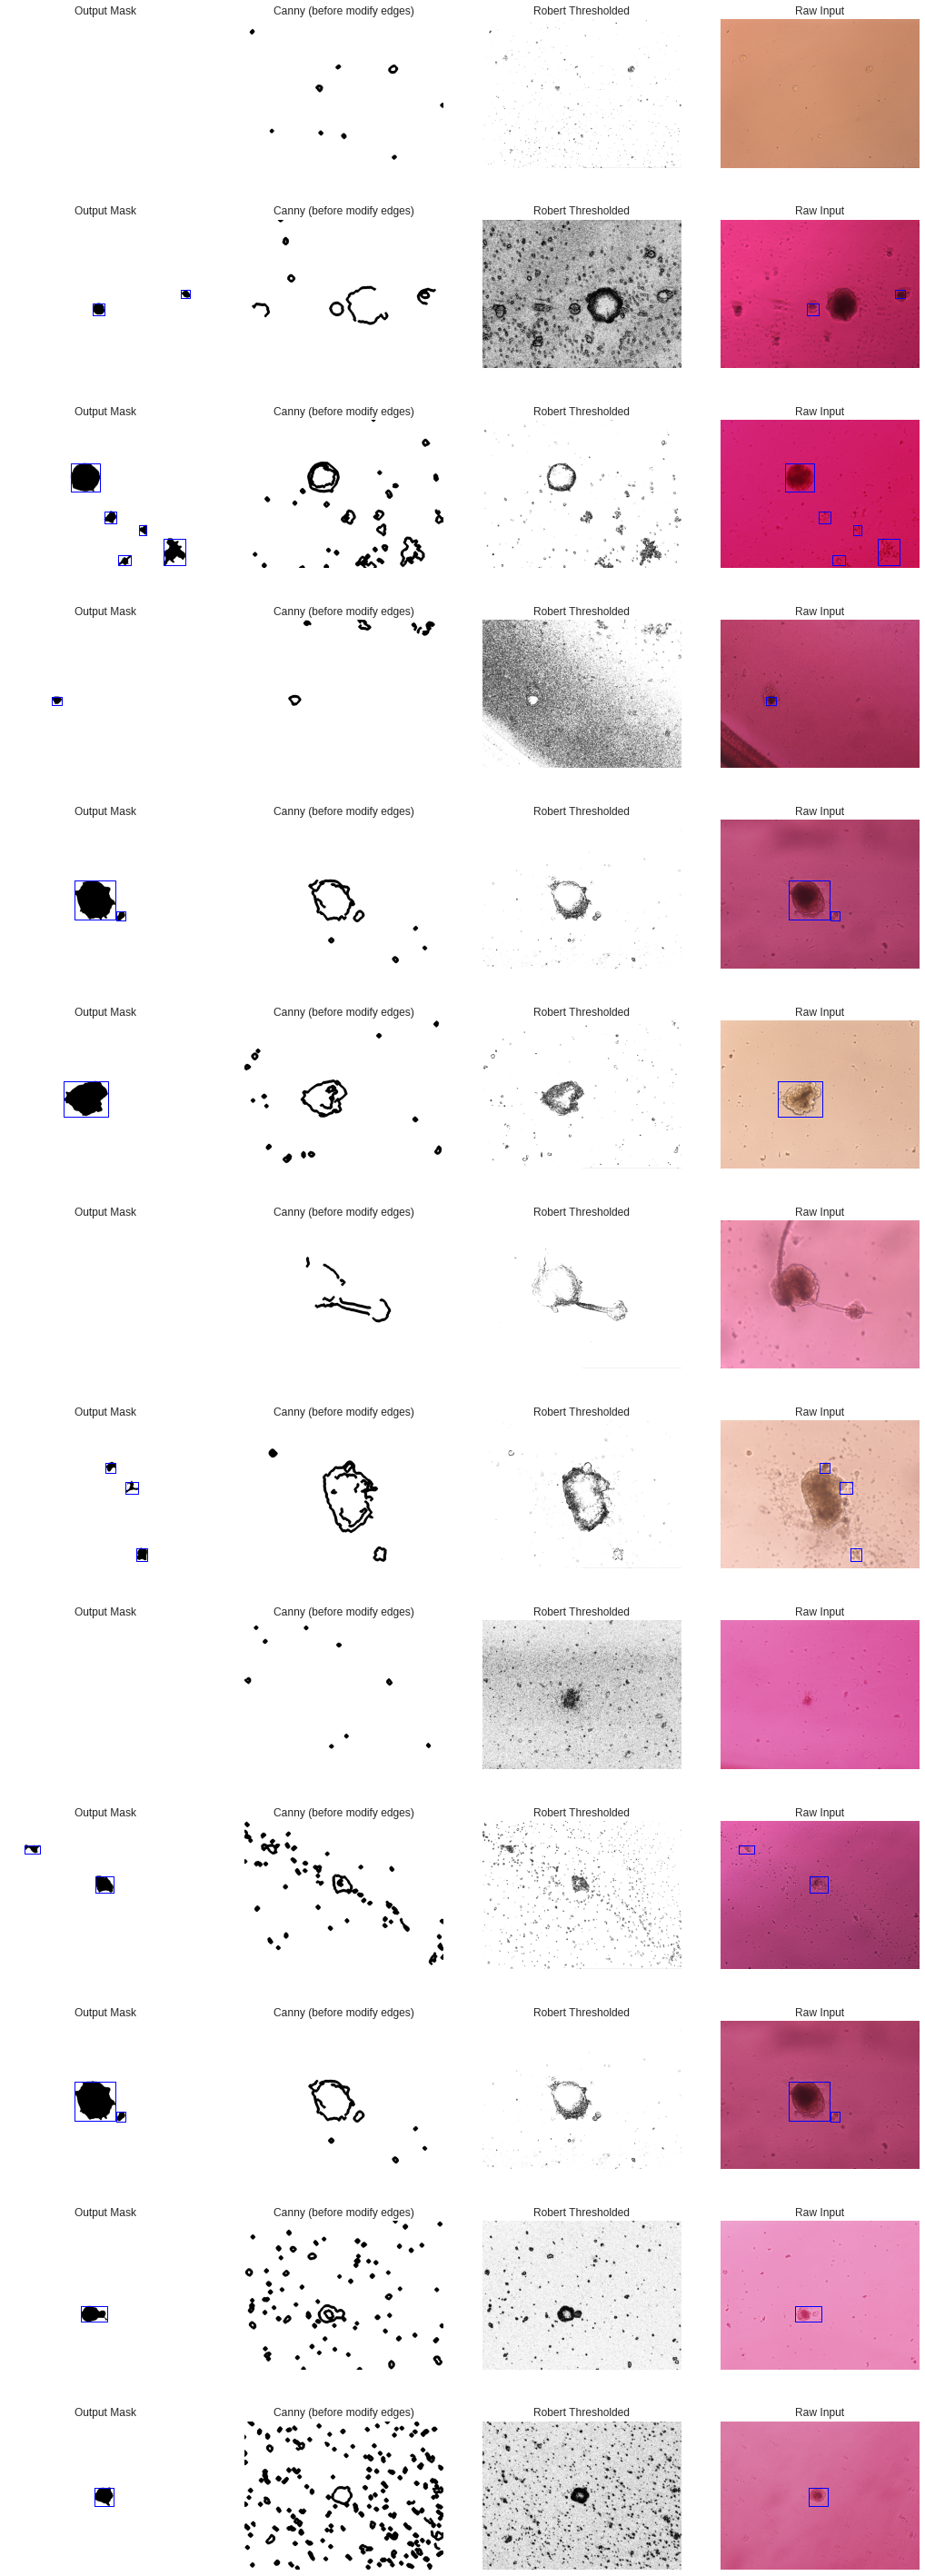

In [ ]:
np.random.seed(101)
n= 13
MASKS, CANNY, SAMPLES, RAWS, FEATURES, REGIONS= mask_process(n)

titl= ['Output Mask', 'Canny (before modify edges)', 'Robert Thresholded', 'Raw Input']
fig, ax= plt.subplots (n, 4, figsize= [18, n*4])
for j in range (n):
    ax[j, 0].imshow(MASKS[j])
    ax[j, 1].imshow(CANNY[j])
    ax[j, 2].imshow(SAMPLES[j])
    ax[j, 3].imshow(RAWS[j])         

    for props in REGIONS[j]:
        if props.eccentricity < 0.92:
            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)

            ax[j, 3].plot(bx, by, '-b', linewidth=1)
            ax[j, 0].plot(bx, by, '-b', linewidth=1)

    
    [ax[j, i].set_xticks([]) for i in range (4)]
    [ax[j, i].set_yticks([]) for i in range (4)]
    [ax[j, i].grid() for i in range (4)]
    [ax[j, i].set_title(titl[i]) for i in range (4)]

In [ ]:
# It is seen that these traditional methodes are not the best for our data in general 
# and fails to segment challenging espheroids.
# The need to an intelligent method is apparent from samples results, due to variety in noises. 

# Save Masks


In [ ]:
# np.random.seed (100)
for img in tqdm(L2):
    image1= cv2.imread (img)
    smpl, raw= img_loader(image1)
    msk, _= mask(smpl)

    label_img = label(msk)
    regions= regionprops(label_img)
    benchmark= [regions[i].eccentricity <.91 for i in range (len (regions))]
    # regions1= list(compress(regions, benchmark))
    for j, ben in enumerate(benchmark):
        if not ben:
            label_img[label_img == j+1] = 0
    msk= label_img.astype (bool)

    name= img.split ('.tif')[0]
    np.save (f'{name}', msk.astype (bool))

    fig= plt.figure()
    ax= fig.add_axes ([0,0,1,1])
    ax.set_xticks ([])
    ax.set_yticks ([])
    plt.axis('off')
    ax.imshow(msk);
    plt.savefig(f'{name}.png', dpi=fig.dpi)
    plt.close('all')
    del image1, smpl, raw, msk

# Make dataframe

In [ ]:
mmm= glob.glob('**/**/**/**.npy')
len (mmm)

In [ ]:
cols= ['Name','Dir','Den','Day','centroid-0','centroid-1','orientation','major_axis_length','minor_axis_length',
       'eccentricity','solidity','perimeter','perimeter_crofton','area','convex_area','convex_perimeter']

In [ ]:
DF= pd.DataFrame (columns=cols)
for m in tqdm(mmm):
    msk= np.load(m)
    label_img = label(msk)
    props = regionprops_table(label_img, extra_properties=(convex_perimeter,), 
                                         properties=('centroid', 'orientation', 'major_axis_length', 'minor_axis_length',
                                                     'eccentricity', 'solidity','perimeter', 'perimeter_crofton', 'area', 'convex_area',))
    df= pd.DataFrame(props)
    name= m.split ('.npy')[0]
    Dir, Den, Day, Name= name.split ('/')
    df[['Dir', 'Den', 'Day', 'Name']]= Dir, Den, Day, Name
    DF= pd.concat([DF, df])

DF['Convexity'] = DF.convex_perimeter / DF.perimeter
DF['Compactness']= DF.area * 4*pi / DF.perimeter
DF.index.name='ind'
DF.to_csv('RESULTS/Dataframe_104_1.csv', index= 'ind')

# END